In [22]:
# https://pythonprogramming.net/training-deep-learning-neural-network-pytorch/
import torch
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F  # similar as nn, most times both would work
import torch.optim as optim

### Download train and test sets

In [23]:
train = datasets.MNIST("", train=True, download=True,
                      transform=transforms.Compose([transforms.ToTensor()]))

test = datasets.MNIST("", train=False, download=True,
                      transform=transforms.Compose([transforms.ToTensor()]))

In [24]:
# increasing batch size decreases training time, but your computer might have limitations
trainset = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)
test = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)

### Visualising data

In [25]:
for data in trainset:
    print(data)
    break

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0

In [26]:
# data[0] is a bunch of features, data[1] is the labels
# e.g. if data[1][0] is a 2 label, data[0][0]'s features are a 2, data[0][0] is 1 x 28 x 28 as seen below
x, y = data[0][0], data[1][0]

print(y)

tensor(4)


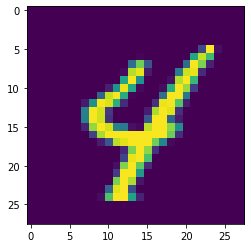

In [27]:
# print(data[0][0].shape) # returns torch.Size([1, 28, 28]). Since this has a 1 in front, need to reshape
# plt.imshow(data[0][0]) # just using this would return Invalid shape (1, 28, 28) for image data

plt.imshow(data[0][0].view(28, 28))

In [28]:
# checking if dataset is balanced and has equal number of features for all labels
total = 0 
counter_dict = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}

for data in trainset:
    Xs, ys = data
    for y in ys:
        counter_dict[int(y)] += 1
        total += 1

print(counter_dict)

for i in counter_dict:
    print(f"{i}: {counter_dict[i] / total * 100}")

{0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
0: 9.871666666666666
1: 11.236666666666666
2: 9.93
3: 10.218333333333334
4: 9.736666666666666
5: 9.035
6: 9.863333333333333
7: 10.441666666666666
8: 9.751666666666667
9: 9.915000000000001


In [29]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()  #???
        self.fc1 = nn.Linear(28 * 28, 64)  # flattened 28 * 28 img size for input, any number for output going to next layer
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 10)  # classify into 10 classes (0 to 9)
    
    # now we want to define how the data passes through, and which layer is first
    # sidenote: if you want to include logic, you can add that here as well
    def forward(self, x):
        # for hidden layers, want relu to determine if neuron "fires" or not
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        # for last layer, want a probability distribution, then can take the class w/ highest probability
        x = self.fc4(x)
        # dim=1 grabbing the output values
        return F.log_softmax(x, dim=1)

### Testing with a random input

In [30]:
net = Net()
# print(net)
X = torch.rand((28, 28))
# X = X.view(28 * 28) # will give you Dimension out of range (expected to be in range of [-1, 0], but got 1) error
X = X.view(-1, 28 * 28)  # -1 or 1 specifies input is of unknown shape
output = net(X)
# this shows that we can successfully pass through data in our NN class even w/o any grad descent optimisation etc
output

tensor([[-2.3461, -2.2938, -2.2629, -2.3187, -2.3039, -2.2898, -2.3865, -2.3343,
         -2.2424, -2.2561]], grad_fn=<LogSoftmaxBackward>)

### Loss function

In [31]:
# can tell model to not adjust "well optimised" earlier layer weights, and only adjust later layers
optimizer = optim.Adam(net.parameters(), lr=0.001)

EPOCHS = 3

for epoch in range(EPOCHS):
    # data is a batch of featuresets and labels
    for data in trainset:
        X, y = data
        net.zero_grad()
        output = net(X.view(-1, 28 * 28))  # return a 1x10 tensor that has probability for each label
        loss = F.nll_loss(output, y)
        loss.backward()  # backprop
        optimizer.step()  
    print(loss)

tensor(0.1267, grad_fn=<NllLossBackward>)
tensor(0.0744, grad_fn=<NllLossBackward>)
tensor(0.0014, grad_fn=<NllLossBackward>)


### Calc accuracy and double check w/ sample data

In [32]:
correct = 0
total = 0

# disables gradient calc https://pytorch.org/docs/stable/generated/torch.no_grad.html
# don't want to calc gradient here, just testing how good model is
with torch.no_grad():
    for data in trainset:
        X, y = data
        output = net(X.view(-1, 28 * 28))
        # argmax returns indice of largest value
        # since indices are ordered by label from 0 to 9, that also returns the predicted label
        # compare predicted against actual value in the idx-th entry of y e.g. 0th entry, 1st entry
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1
            
print("Accuracy: ", round(correct / total, 3))

Accuracy:  0.972


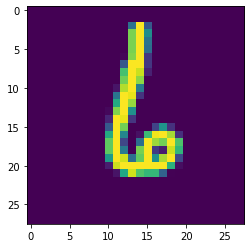

tensor(6)


In [33]:
plt.imshow(X[0].view(28, 28))
plt.show()  # visualise feature/label
print(torch.argmax(net(X[0].view(-1, 28 * 28))[0]))  # check what label was